# Jul 7th, 2022 (Fig-3 OCs; combined)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.mouse import Mice
from model.configuration import Config
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 512
fig_dir = 'Fig3_OCs'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512/Fig3_OCs

## Prepare (512)

In [3]:
mice = Mice(nn)
task = 'rest'

num_k, p = 20, 20
perc = f'p{p}-sample'
props_base = {
    'kw_kmeans': {'n_init': 100},
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

bt = BootStrap(**props_ca)
bt_bo = BootStrap(**props_bo)

mice.setup_func_data(task, band_ca=(0.01, 0.5))
bt_cas = BootStrap(**props_ca)

mice.setup_func_data(task, band_ca=0.5)
bt_caf = BootStrap(**props_ca)

bt_dict = {
    BOLD: bt_bo,
    CAS: bt_cas,
    CAF: bt_caf,
}

## Get results

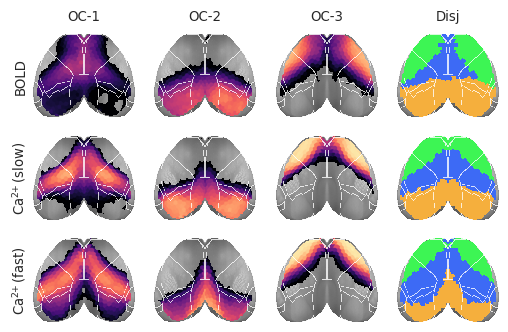

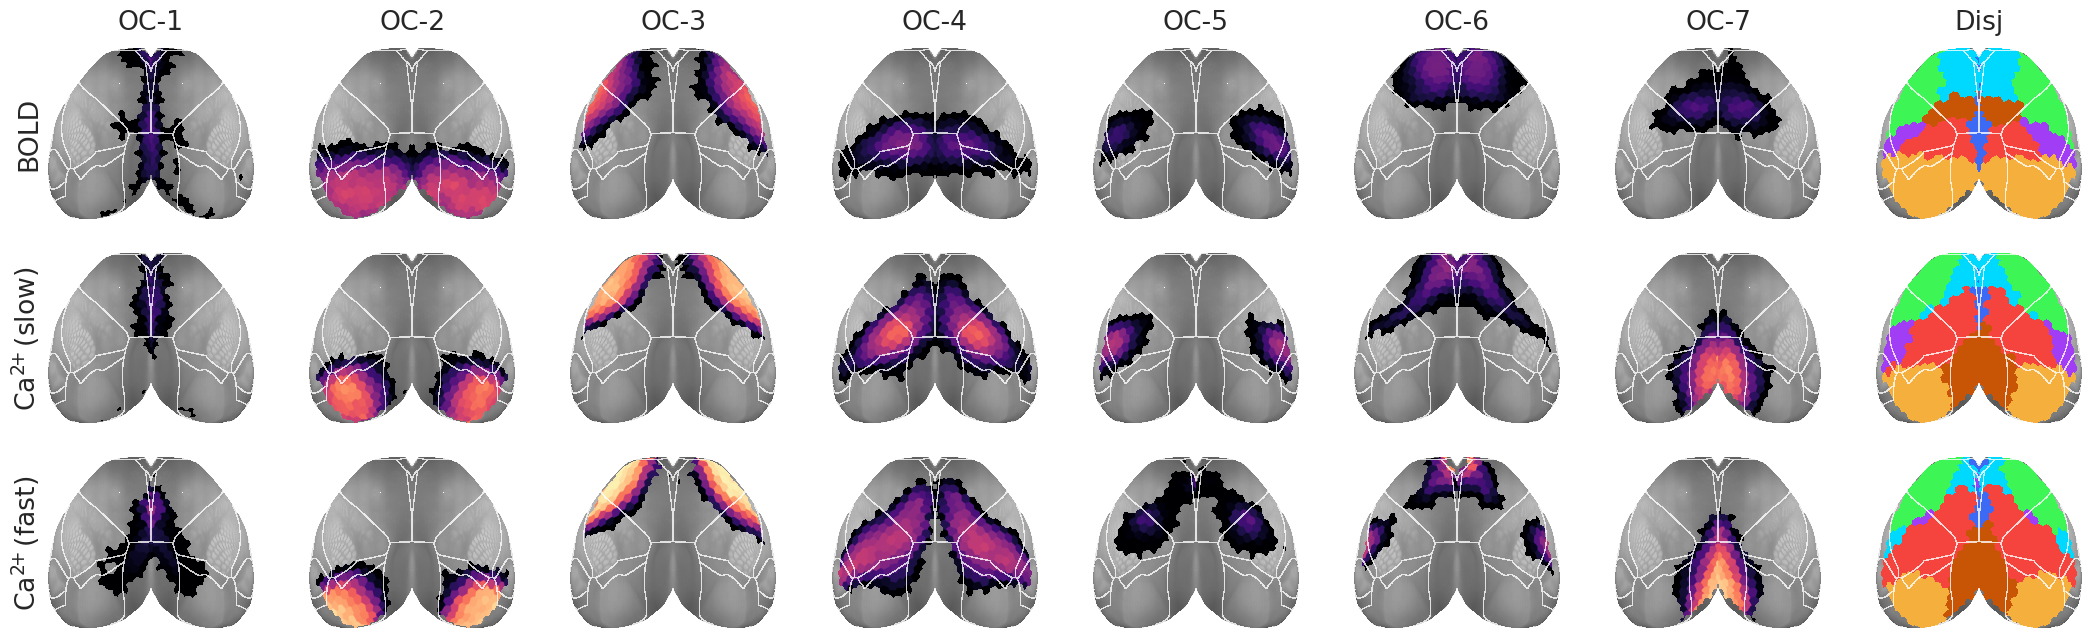

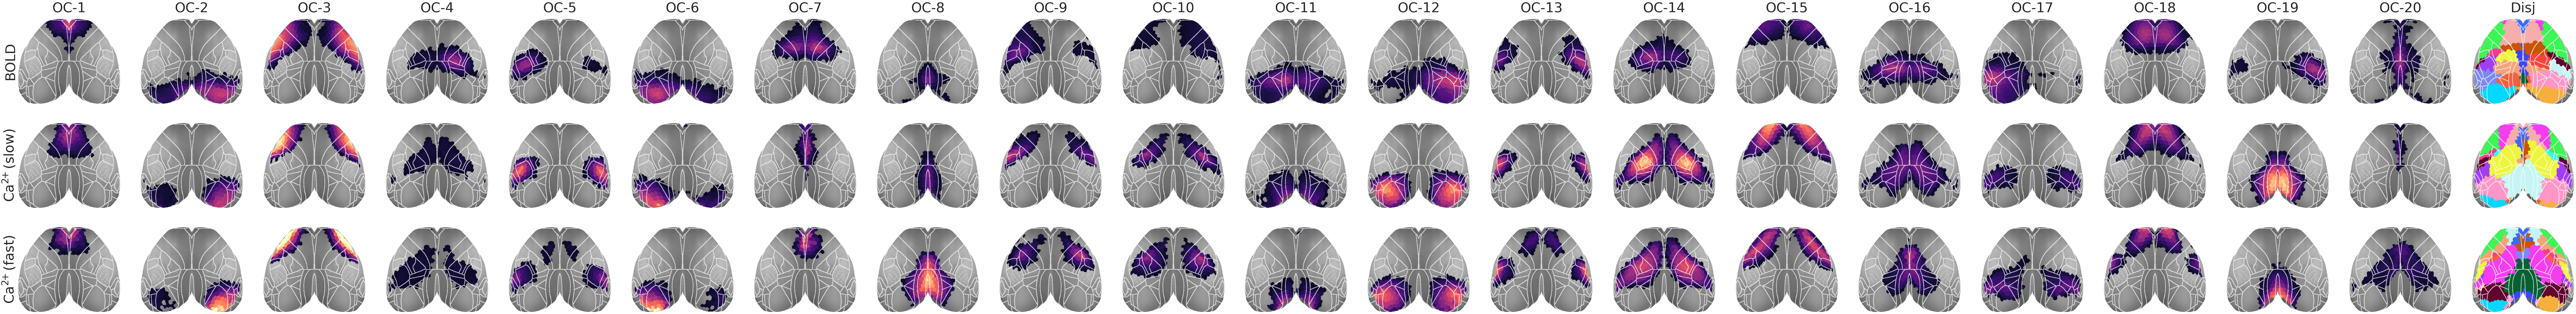

CPU times: user 39min 9s, sys: 1min 59s, total: 41min 8s
Wall time: 41min 9s


In [4]:
%%time

results = {}
for kk in [3, 7, 20]:
    props_ca['num_k'] = kk
    props_bo['num_k'] = kk
    if kk == 7:
        props_bo['num_k'] += 1
        thres = 0.372
    else:
        thres = None
    
    if kk == 3:
        kws_show = {
            'vmin': 0.2,
            'vmax': 1.0,
            'mask_thresh': 1 / 7,
            'add_disjoint': True,
            'add_title': True,
            'figsize_x': 2.5,
            'dpi': 100,
        }
    elif kk == 7:
        kws_show = {
            'vmin': 0.2,
            'vmax': 1.0,
            'mask_thresh': 1 / 7,
            'add_disjoint': True,
            'add_title': True,
        }
    elif kk == 20:
        kws_show = {
            'vmin': 0,
            'vmax': 0.7,
            'mask_thresh': 1 / 20,
            'contour_alpha': 0.7,
            'contour_width': 0.2,
            'contour_coarse': False,
            'add_disjoint': True,
            'add_title': True,
            'figsize_x': 13.5,
        }

    bt = BootStrap(**props_ca)
    bt_bo = BootStrap(**props_bo)
    mice.setup_func_data(task, band_ca=(0.01, 0.5))
    bt_cas = BootStrap(**props_ca)
    mice.setup_func_data(task, band_ca=0.5)
    bt_caf = BootStrap(**props_ca)
    bt_dict = {
        BOLD: bt_bo,
        CAS: bt_cas,
        CAF: bt_caf,
    }

    res = similiarity_results(
        bt_dict=bt_dict,
        merge_thres=thres,
        n_resamples=int(1e5),
    )
    results[kk] = res
    
    _ = bt.show(
        data=res['pi_sorted'],
        **kws_show,
    )

## Overall sim box plt

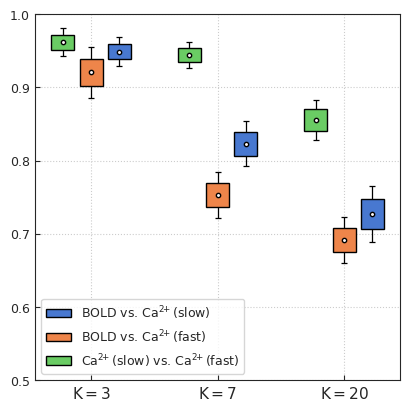

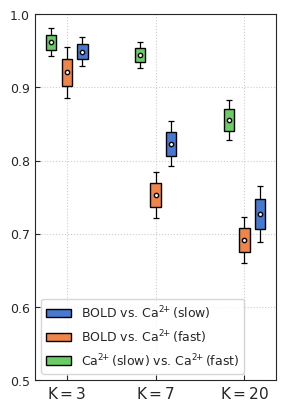

In [5]:
from figures.fig_ocs import similarity_box as go
_ = go(results, width=0.27,)
fig, _ = go(results)

fig.savefig(pjoin(fig_dir, 'sim_bx.pdf'), **kws_fig)
fig.savefig(pjoin(fig_dir, 'sim_bx.png'), **kws_fig)

### FDR correction

In [13]:
pvals = {}
for kk, res in results.items():
    for k, test in res['tests'].items():
        pvals[(kk, ) + k] = test.pvalue

In [24]:
reject, *_ = multipletests(
    pvals=list(pvals.values()),
    method='fdr_bh',
    alpha=0.001,
)
reject

array([ True,  True,  True,  True,  True,  True, False,  True,  True])

In [26]:
reject, *_ = multipletests(
    pvals=list(pvals.values()),
    method='fdr_bh',
    alpha=0.01,
)
reject

array([ True,  True,  True,  True,  True,  True, False,  True,  True])

In [27]:
reject, *_ = multipletests(
    pvals=list(pvals.values()),
    method='fdr_bh',
    alpha=0.05,
)
reject

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

## Make coarse + fine contour

In [232]:
from figures.fighelper import ctx2ax

cmap_coarse = matplotlib.colors.ListedColormap(
    colors=['w', '#1995E6'], name='coarse')
cmap_fine = matplotlib.colors.ListedColormap(
    colors=['w', '#EDBC12'], name='fine')

In [270]:
contour_coarse = bt.get_contour(0.9, True)
contour_fine = bt.get_contour(0.4, False)
contour_delta = np.logical_xor(contour_fine, contour_coarse)

top = filter_boundaries(bt.topview, bt.topview > 0)

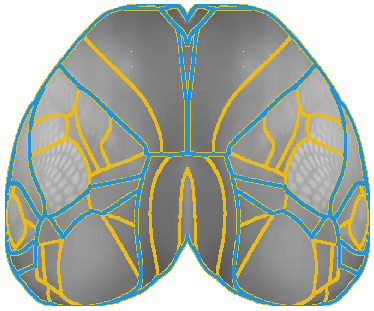

In [271]:
fig, ax = create_figure(1, 1, figsize=(10, 8), dpi=50, tight_layout=False, constrained_layout=False)
plt.imshow(mwh(top == 0, top), cmap='Greys_r')
plt.imshow(
    X=mwh(contour_coarse == 0, contour_coarse),
    cmap=cmap_coarse,
    vmin=0,
    vmax=1,
    alpha=1.0,
    interpolation='none',
)
plt.imshow(
    X=mwh(contour_delta == 0, contour_delta),
    cmap=cmap_fine,
    vmin=0,
    vmax=1,
    alpha=1.0,
    interpolation='none',
)
remove_ticks(ax)

In [263]:
contour_coarse = bt.get_contour(0.5, True)

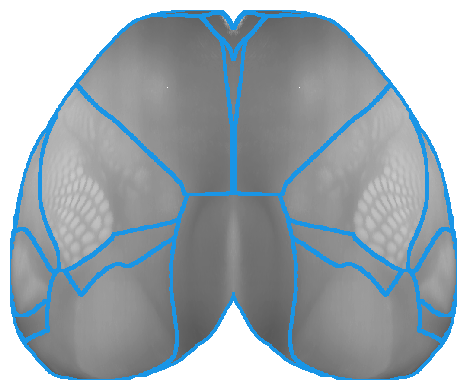

In [264]:
fig, ax = create_figure(dpi=100)
plt.imshow(mwh(top == 0, top), cmap='Greys_r')
plt.imshow(
    X=mwh(contour_coarse == 0, contour_coarse),
    cmap=cmap_coarse,
    vmin=0,
    vmax=1,
    alpha=1.0,
    interpolation='none',
)
remove_ticks(ax)

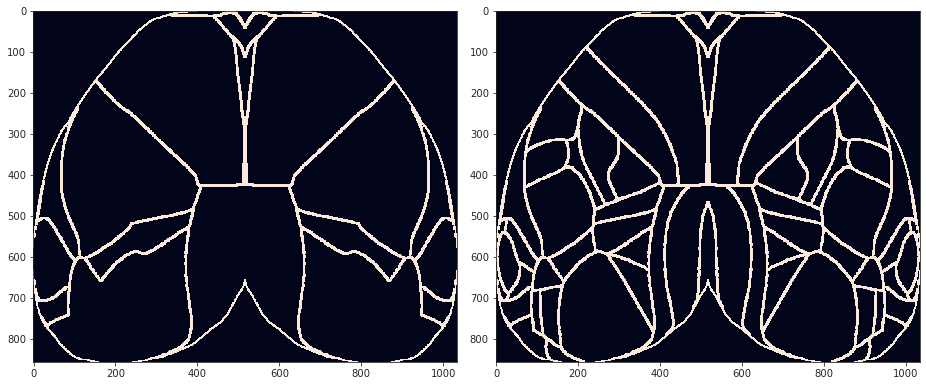

In [189]:
fig, axes = create_figure(1, 2, (13, 15))
axes[0].imshow(contour_coarse)
axes[1].imshow(contour_fine);

In [144]:
contour = contour_fine.copy().astype(float)
contour[contour_coarse] = 2

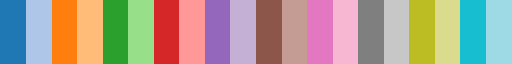

In [145]:
sns.color_palette('tab20', as_cmap=True)

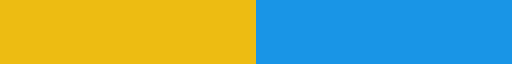

In [166]:
# colors = sns.color_palette('tab20', n_colors=20)
colors = ['#EDBC12', '#1995E6'] # ['#2F52D0', '#D0AD2F']
cmap = matplotlib.colors.ListedColormap(colors)
cmap

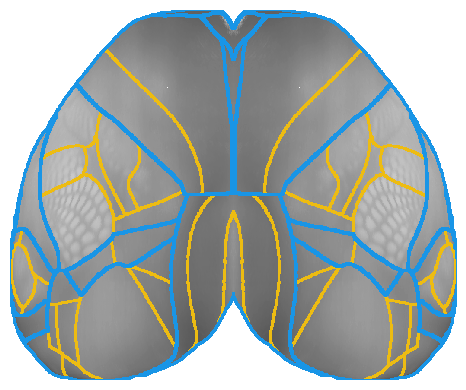

In [169]:
fig, ax = create_figure(dpi=100)
plt.imshow(mwh(top == 0, top), cmap='Greys_r')
plt.imshow(mwh(contour == 0, contour), cmap=cmap, interpolation='none')
remove_ticks(ax)

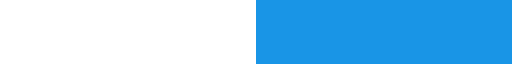

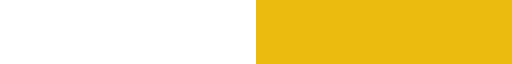

In [191]:

cmap_fine

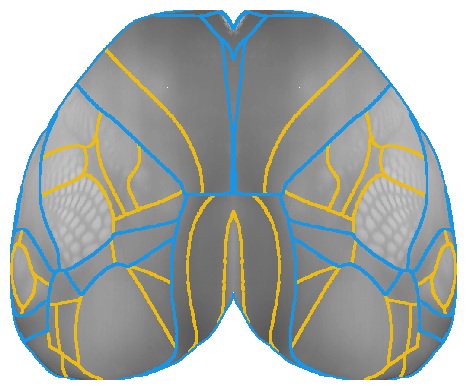

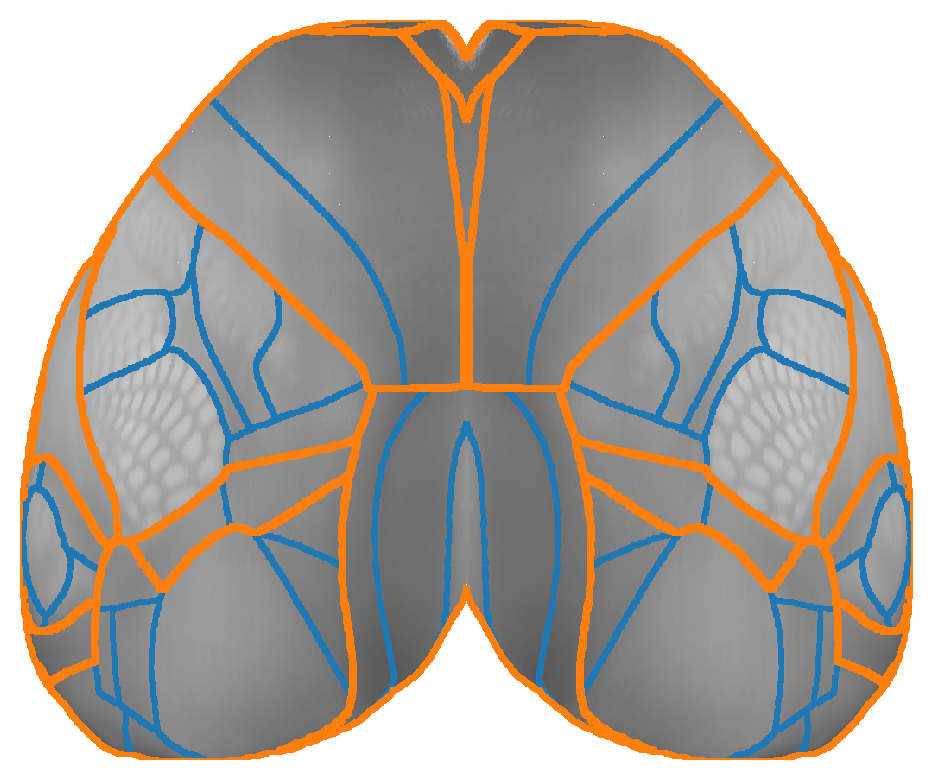

In [57]:
fig, ax = create_figure(dpi=200)
plt.imshow(mwh(top == 0, top), cmap='Greys_r')
plt.imshow(mwh(contour == 0, contour), cmap=cmap, interpolation='none')
remove_ticks(ax)